Eastern (_A): 16940 valid Δ pairs (DST-safe)
East Midlands (_B): 16940 valid Δ pairs (DST-safe)
London (_C): 16940 valid Δ pairs (DST-safe)
Merseyside & North Wales (_D): 16940 valid Δ pairs (DST-safe)
Midlands (_E): 16940 valid Δ pairs (DST-safe)
Northern (_F): 16940 valid Δ pairs (DST-safe)
North Western (_G): 16940 valid Δ pairs (DST-safe)
Southern (_H): 16940 valid Δ pairs (DST-safe)
South Eastern (_J): 16940 valid Δ pairs (DST-safe)
South Wales (_K): 16940 valid Δ pairs (DST-safe)
South Western (_L): 16940 valid Δ pairs (DST-safe)
Yorkshire (_M): 16940 valid Δ pairs (DST-safe)
South of Scotland (_N): 16940 valid Δ pairs (DST-safe)
North of Scotland (_P): 16940 valid Δ pairs (DST-safe)


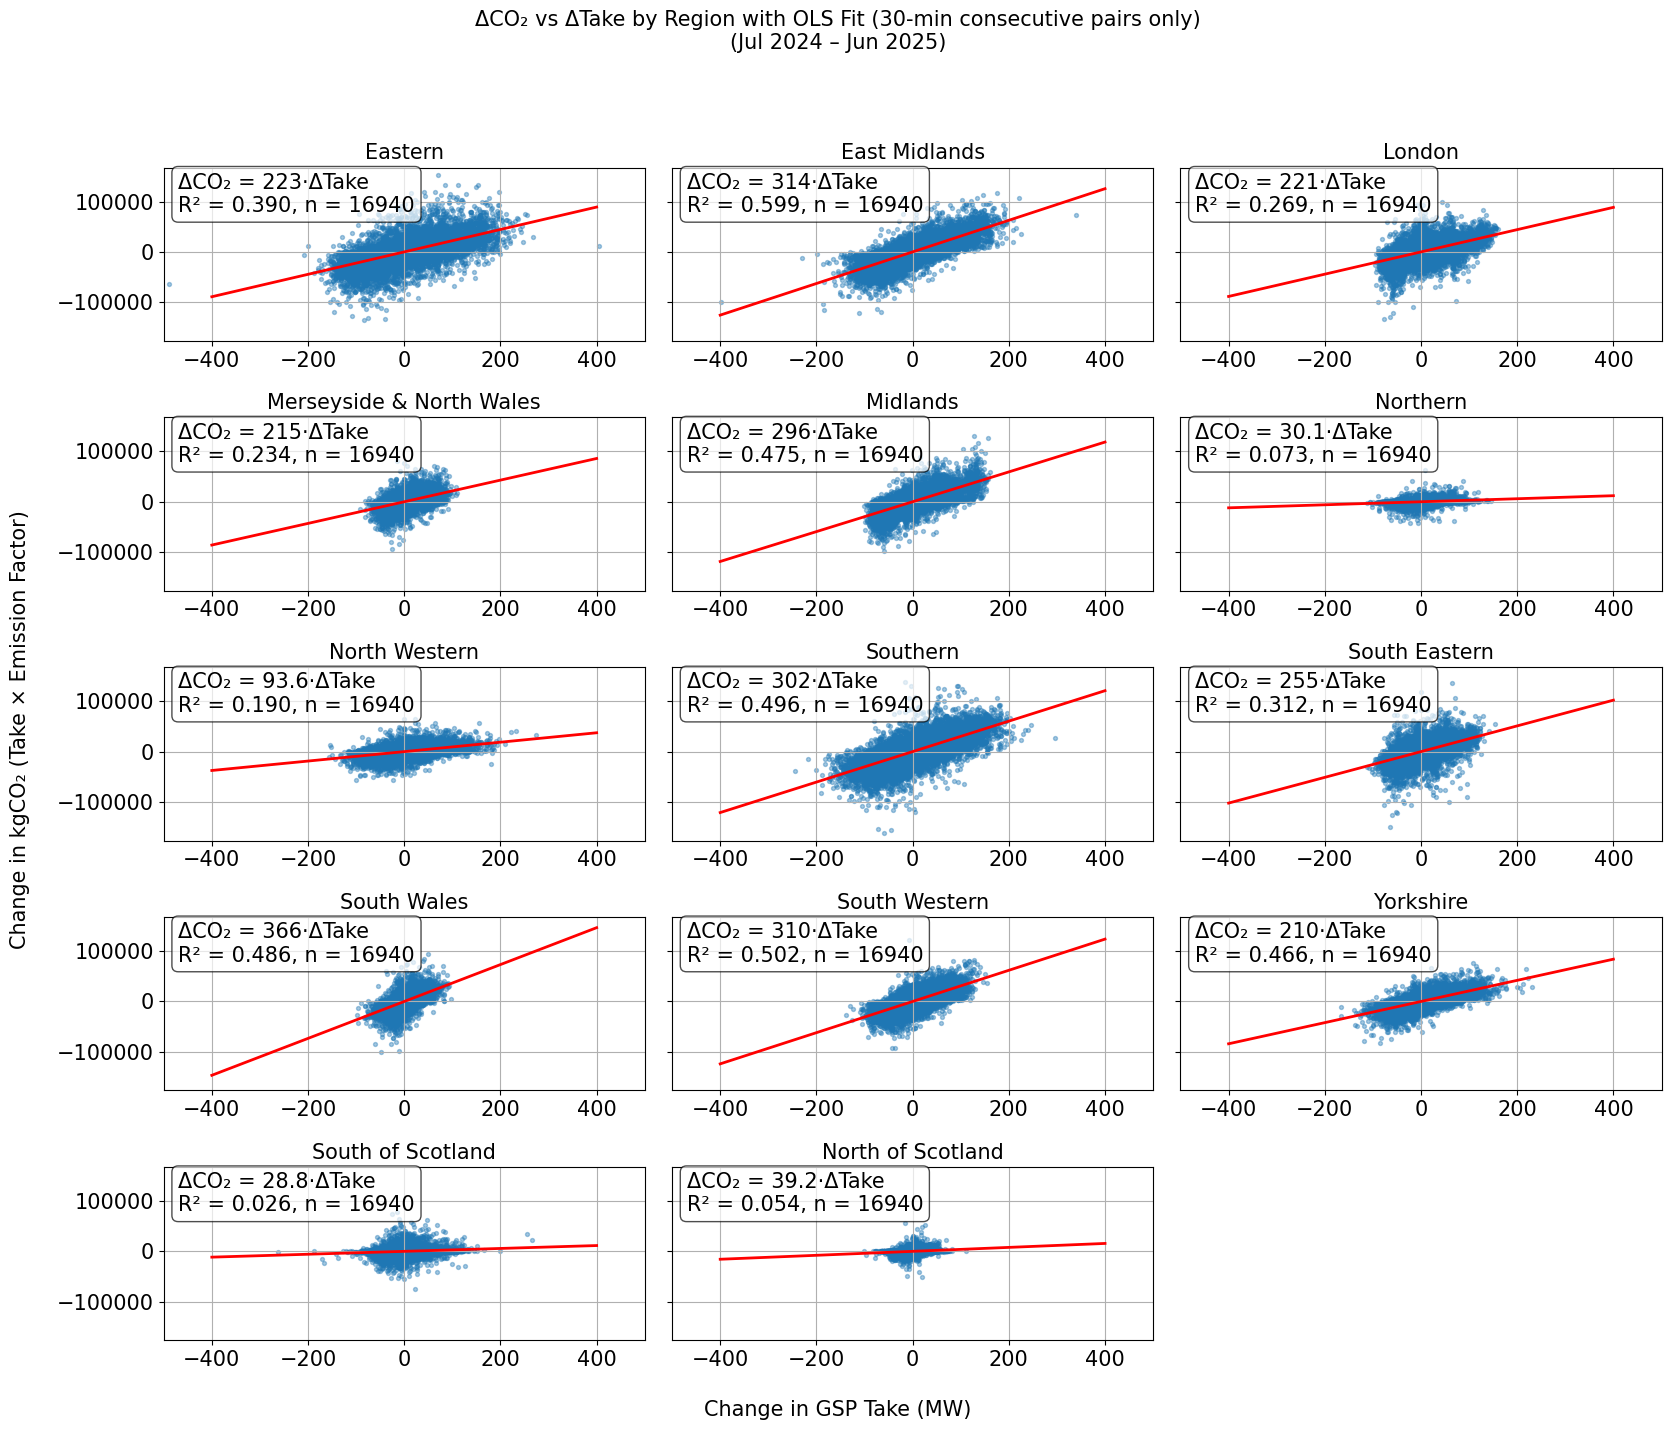

Saved regression summary to: C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25_regional_deltas_regression_summary.csv


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# === GLOBAL FONT SIZES (min 14) ===
plt.rcParams.update({
    "font.size": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})

# === CONFIG ===
SAVE_SUMMARY_CSV = True  # <- set to True to write summary CSV next to input file

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes and descriptions ===
region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# === Setup subplots ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharey=True)
axes = axes.flatten()

# Collect results for optional CSV
summary_rows = []

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'

    if take_col not in df.columns or ci_col not in df.columns:
        ax.set_visible(False)
        print(f"Skipping {code} (columns missing)")
        continue

    # Bring in date/period to handle DST correctly
    region_df = df[['datetime', 'SettlementDate', 'SettlementPeriod', take_col, ci_col]].dropna().copy()
    region_df.rename(columns={take_col: 'Take', ci_col: 'CI'}, inplace=True)
    region_df = region_df.sort_values(['SettlementDate', 'SettlementPeriod'])

    # CO2 at each timestamp
    region_df['CO2'] = region_df['Take'] * region_df['CI']

    # Previous row's date/period
    region_df['prev_date']  = region_df['SettlementDate'].shift(1)
    region_df['prev_sp']    = region_df['SettlementPeriod'].shift(1)

    # Max SP per day (46/48/50); we need the *previous* day’s max to check wrap
    max_sp_per_day = region_df.groupby('SettlementDate')['SettlementPeriod'].transform('max')
    region_df['max_sp_today'] = max_sp_per_day
    # Map of date -> max SP, then look up previous day's max
    prev_day_max = region_df[['SettlementDate', 'max_sp_today']].drop_duplicates().set_index('SettlementDate')['max_sp_today']
    region_df['max_sp_prev'] = region_df['prev_date'].map(prev_day_max)

    # Define "consecutive settlement periods"
    same_day_next_sp = (
        (region_df['SettlementDate'] == region_df['prev_date']) &
        (region_df['SettlementPeriod'] == region_df['prev_sp'] + 1)
    )
    wrap_to_new_day = (
        (region_df['SettlementDate'] != region_df['prev_date']) &
        (region_df['prev_sp'] == region_df['max_sp_prev']) &
        (region_df['SettlementPeriod'] == 1)
    )
    consecutive = same_day_next_sp | wrap_to_new_day

    # First differences and keep only true consecutive pairs
    region_df['Δ_Take'] = region_df['Take'].diff()
    region_df['Δ_CO2']  = region_df['CO2'].diff()
    region_df = region_df[consecutive].dropna(subset=['Δ_Take', 'Δ_CO2']).copy()

    # Count datapoints
    n_points = len(region_df)
    print(f"{region_descriptions[code]} ({code}): {n_points} valid Δ pairs (DST-safe)")

    if n_points < 3:
        ax.set_visible(False)
        continue

    x = region_df['Δ_Take'].to_numpy().reshape(-1, 1)
    y = region_df['Δ_CO2'].to_numpy().reshape(-1, 1)

    reg = LinearRegression(fit_intercept=False).fit(x, y)
    m = float(reg.coef_[0, 0])     # slope
    r2 = float(reg.score(x, y))
    b = 0.0                        # intercept forced to zero by fit_intercept=False

    # Collect row for optional CSV
    summary_rows.append({
        "region_code": code,
        "region_name": region_descriptions[code],
        "slope": m,
        "intercept": b,
        "r_squared": r2,
        "n_obs": n_points
    })

    ax.scatter(region_df['Δ_Take'], region_df['Δ_CO2'], s=8, alpha=0.4)
    x_line = np.linspace(-400, 400, 200).reshape(-1, 1)
    ax.plot(x_line, reg.predict(x_line), color='red', linewidth=2)

    ax.set_title(region_descriptions[code], fontsize=15)
    ax.text(0.03, 0.97,
            f"ΔCO₂ = {m:.3g}·ΔTake\nR² = {r2:.3f}, n = {n_points}",
            ha='left', va='top', transform=ax.transAxes,
            fontsize=15, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    ax.set_xlim(-500, 500)  # <- standardised x-axis
    ax.grid(True)

# Hide any unused subplot (should be exactly one)
for j in range(len(region_codes), len(axes)):
    axes[j].axis('off')

# Shared labels and layout
fig.supxlabel('Change in GSP Take (MW)', fontsize=15, y=0.04)
fig.supylabel('Change in kgCO₂ (Take × Emission Factor)', fontsize=15, x=0.04)
fig.suptitle('ΔCO₂ vs ΔTake by Region with OLS Fit (30-min consecutive pairs only)\n(Jul 2024 – Jun 2025)', fontsize=15)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()

# === Optional: write summary CSV ===
if SAVE_SUMMARY_CSV and summary_rows:
    summary_df = pd.DataFrame(summary_rows)
    out_dir = os.path.dirname(csv_path)
    base = os.path.splitext(os.path.basename(csv_path))[0]
    out_path = os.path.join(out_dir, f"{base}_regional_deltas_regression_summary.csv")
    summary_df.to_csv(out_path, index=False)
    print(f"Saved regression summary to: {out_path}")


Eastern (_A): 16940 valid Δ pairs (DST-safe)
East Midlands (_B): 16940 valid Δ pairs (DST-safe)
London (_C): 16940 valid Δ pairs (DST-safe)
Merseyside & North Wales (_D): 16940 valid Δ pairs (DST-safe)
Midlands (_E): 16940 valid Δ pairs (DST-safe)
Northern (_F): 16940 valid Δ pairs (DST-safe)
North Western (_G): 16940 valid Δ pairs (DST-safe)
Southern (_H): 16940 valid Δ pairs (DST-safe)
South Eastern (_J): 16940 valid Δ pairs (DST-safe)
South Wales (_K): 16940 valid Δ pairs (DST-safe)
South Western (_L): 16940 valid Δ pairs (DST-safe)
Yorkshire (_M): 16940 valid Δ pairs (DST-safe)
South of Scotland (_N): 16940 valid Δ pairs (DST-safe)
North of Scotland (_P): 16940 valid Δ pairs (DST-safe)


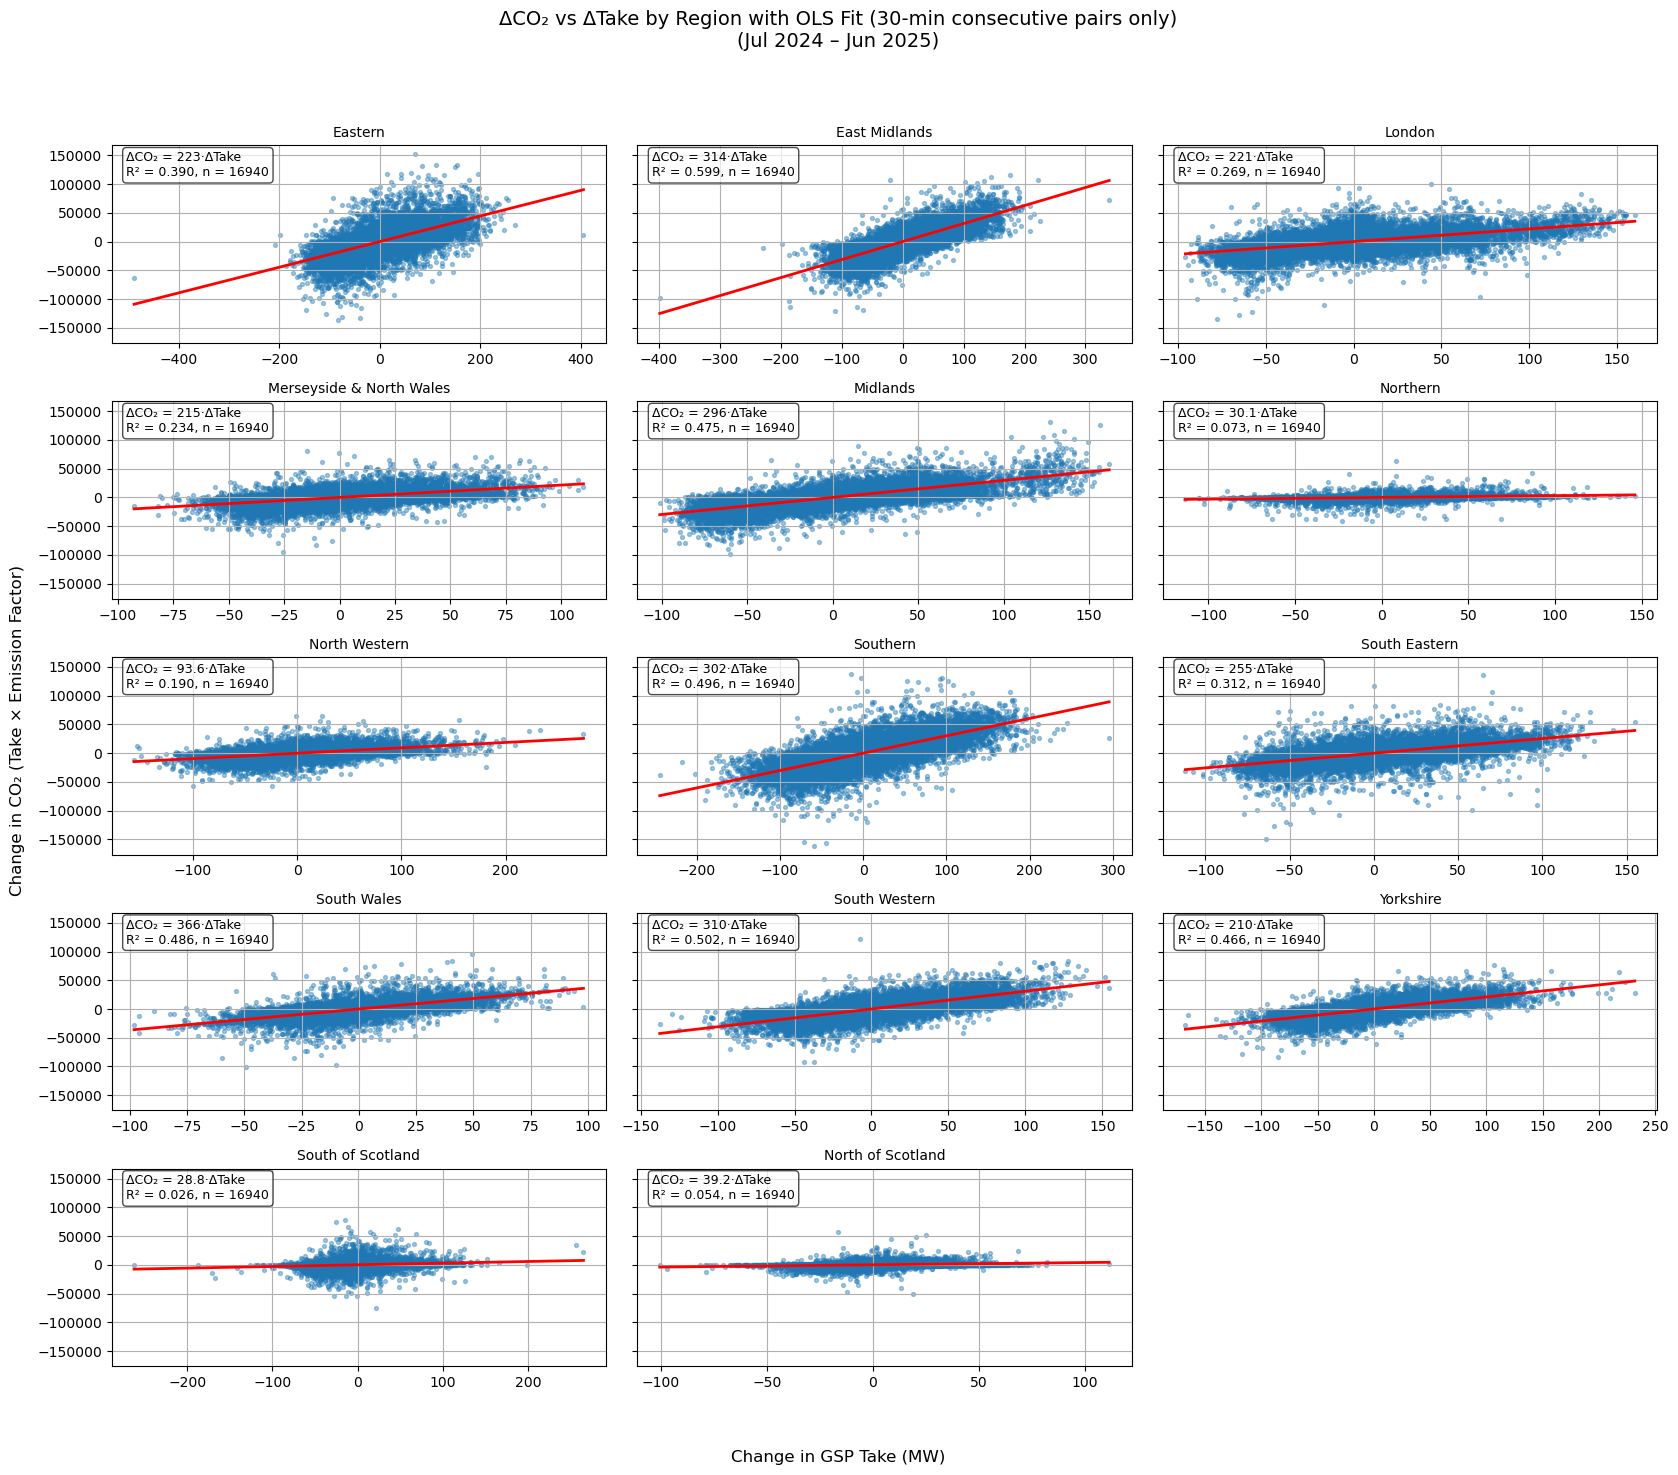

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime and sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.sort_values('datetime')

# === Region codes and descriptions ===
region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# === Setup subplots ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharey=True)
axes = axes.flatten()

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'

    if take_col not in df.columns or ci_col not in df.columns:
        ax.set_visible(False)
        print(f"Skipping {code} (columns missing)")
        continue

    # Bring in date/period to handle DST correctly
    region_df = df[['datetime', 'SettlementDate', 'SettlementPeriod', take_col, ci_col]].dropna().copy()
    region_df.rename(columns={take_col: 'Take', ci_col: 'CI'}, inplace=True)
    region_df = region_df.sort_values(['SettlementDate', 'SettlementPeriod'])

    # CO2 at each timestamp
    region_df['CO2'] = region_df['Take'] * region_df['CI']

    # Previous row's date/period
    region_df['prev_date']  = region_df['SettlementDate'].shift(1)
    region_df['prev_sp']    = region_df['SettlementPeriod'].shift(1)

    # Max SP per day (46/48/50); we need the *previous* day’s max to check wrap
    max_sp_per_day = region_df.groupby('SettlementDate')['SettlementPeriod'].transform('max')
    region_df['max_sp_today'] = max_sp_per_day
    # Map of date -> max SP, then look up previous day's max
    prev_day_max = region_df[['SettlementDate', 'max_sp_today']].drop_duplicates().set_index('SettlementDate')['max_sp_today']
    region_df['max_sp_prev'] = region_df['prev_date'].map(prev_day_max)

    # Define "consecutive settlement periods"
    same_day_next_sp = (
        (region_df['SettlementDate'] == region_df['prev_date']) &
        (region_df['SettlementPeriod'] == region_df['prev_sp'] + 1)
    )
    wrap_to_new_day = (
        (region_df['SettlementDate'] != region_df['prev_date']) &
        (region_df['prev_sp'] == region_df['max_sp_prev']) &
        (region_df['SettlementPeriod'] == 1)
    )
    consecutive = same_day_next_sp | wrap_to_new_day

    # First differences and keep only true consecutive pairs
    region_df['Δ_Take'] = region_df['Take'].diff()
    region_df['Δ_CO2']  = region_df['CO2'].diff()
    region_df = region_df[consecutive].dropna(subset=['Δ_Take', 'Δ_CO2']).copy()

    # Count datapoints
    n_points = len(region_df)
    print(f"{region_descriptions[code]} ({code}): {n_points} valid Δ pairs (DST-safe)")

    if n_points < 3:
        ax.set_visible(False)
        continue

    x = region_df['Δ_Take'].to_numpy().reshape(-1, 1)
    y = region_df['Δ_CO2'].to_numpy().reshape(-1, 1)

    reg = LinearRegression(fit_intercept=False).fit(x, y)
    m = float(reg.coef_[0, 0])
    r2 = float(reg.score(x, y))

    ax.scatter(region_df['Δ_Take'], region_df['Δ_CO2'], s=8, alpha=0.4)
    x_line = np.linspace(region_df['Δ_Take'].min(), region_df['Δ_Take'].max(), 200).reshape(-1, 1)
    ax.plot(x_line, reg.predict(x_line), color='red', linewidth=2)

    ax.set_title(region_descriptions[code], fontsize=10)
    ax.text(0.03, 0.97,
            f"ΔCO₂ = {m:.3g}·ΔTake\nR² = {r2:.3f}, n = {n_points}",
            ha='left', va='top', transform=ax.transAxes,
            fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    ax.grid(True)

# Hide any unused subplot (should be exactly one)
for j in range(len(region_codes), len(axes)):
    axes[j].axis('off')

# Shared labels and layout
fig.supxlabel('Change in GSP Take (MW)', fontsize=12)
fig.supylabel('Change in kgCO₂ (Take × Emission Factor)', fontsize=12, x=0.04)
fig.suptitle('ΔCO₂ vs ΔTake by Region with OLS Fit (30-min consecutive pairs only)\n(Jul 2024 – Jun 2025)', fontsize=14)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()


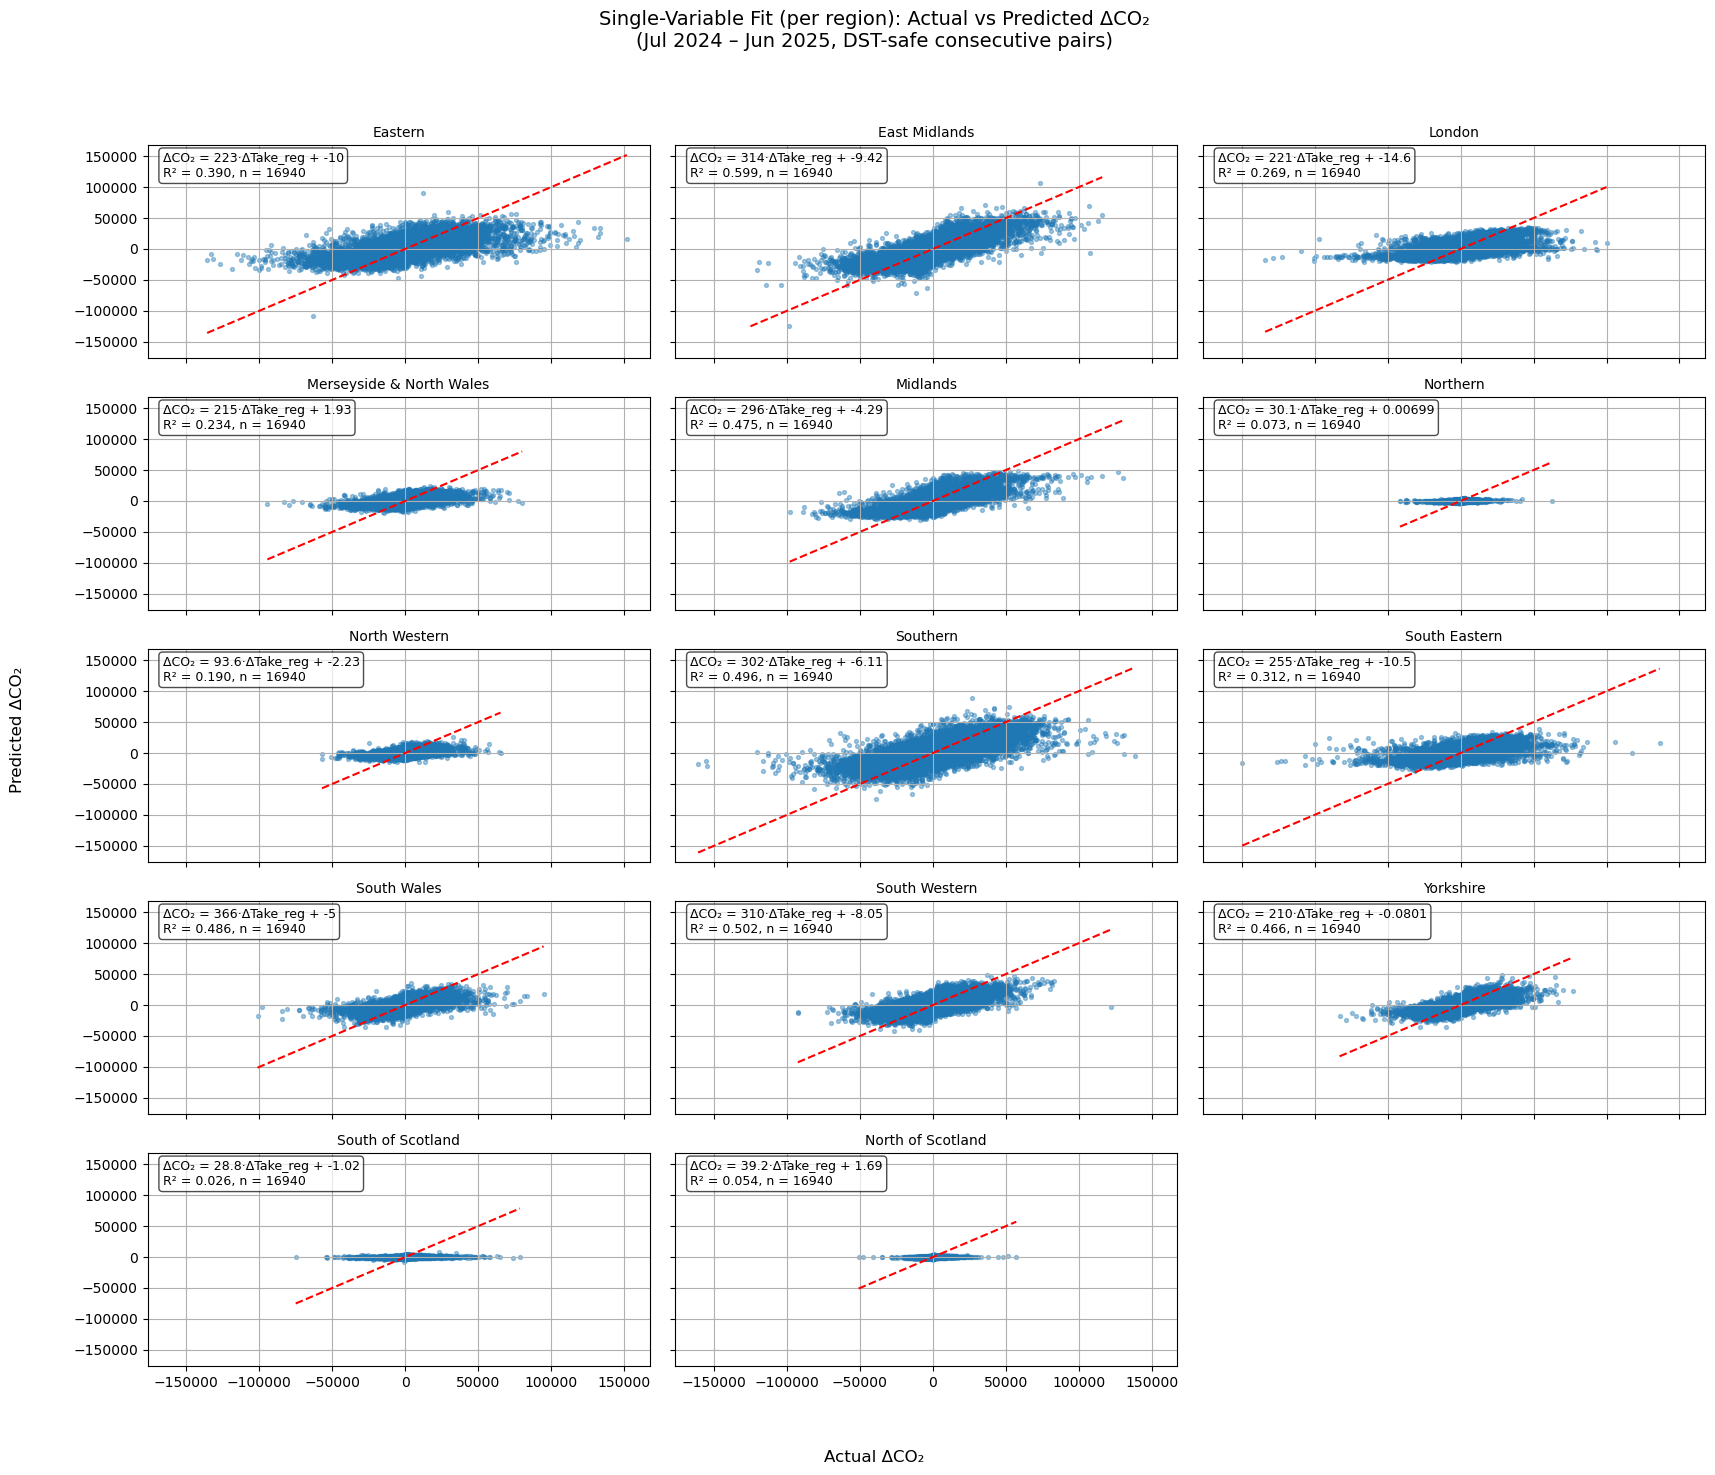

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime + sort
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

# Regions
region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# Precompute CO₂ for all regions
for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col in df.columns and ci_col in df.columns:
        df[f'CO2{code}'] = df[take_col] * df[ci_col]

# === DST-safe consecutive SPs ===
df['prev_date'] = df['SettlementDate'].shift(1)
df['prev_sp']   = df['SettlementPeriod'].shift(1)
max_sp_today = df.groupby('SettlementDate')['SettlementPeriod'].transform('max')
df['max_sp_today'] = max_sp_today
prev_max_map = df[['SettlementDate','max_sp_today']].drop_duplicates().set_index('SettlementDate')['max_sp_today']
df['max_sp_prev'] = df['prev_date'].map(prev_max_map)

same_day_next = (
    (df['SettlementDate'] == df['prev_date']) &
    (df['SettlementPeriod'] == df['prev_sp'] + 1)
)
wrap_new_day = (
    (df['SettlementDate'] != df['prev_date']) &
    (df['prev_sp'] == df['max_sp_prev']) &
    (df['SettlementPeriod'] == 1)
)
df['consecutive'] = same_day_next | wrap_new_day

# === Plot setup ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharex=True, sharey=True)
axes = axes.flatten()

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    take_col = f'GSP_Take{code}'
    co2_col  = f'CO2{code}'

    if take_col not in df.columns or co2_col not in df.columns:
        ax.set_visible(False)
        continue

    # First differences for region
    df['ΔTake_region'] = df[take_col].diff()
    df['ΔCO2_region']  = df[co2_col].diff()

    # Keep only consecutive SPs and valid rows
    subset = df[df['consecutive']].dropna(subset=['ΔTake_region', 'ΔCO2_region']).copy()
    if len(subset) < 3:
        ax.set_visible(False)
        continue

    # Fit single-variable regression: ΔCO2 ~ ΔTake_region
    X = subset[['ΔTake_region']].to_numpy()
    y = subset['ΔCO2_region'].to_numpy()
    reg = LinearRegression().fit(X, y)
    b0 = float(reg.intercept_)
    b1 = float(reg.coef_[0])
    r2 = float(reg.score(X, y))
    n_points = len(subset)

    # Predictions and plot: Actual vs Predicted ΔCO2
    y_pred = reg.predict(X)
    ax.scatter(y, y_pred, s=8, alpha=0.4)
    lims = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
    ax.plot(lims, lims, 'r--', lw=1.5)  # 45° reference line

    ax.set_title(region_descriptions[code], fontsize=10)
    ax.text(0.03, 0.97,
            f"ΔCO₂ = {b1:.3g}·ΔTake_reg + {b0:.3g}\nR² = {r2:.3f}, n = {n_points}",
            ha='left', va='top', transform=ax.transAxes,
            fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    ax.grid(True)

# Hide unused subplot if any
for j in range(len(region_codes), len(axes)):
    axes[j].axis('off')

# Shared labels
fig.supxlabel('Actual ΔCO₂', fontsize=12)
fig.supylabel('Predicted ΔCO₂', fontsize=12)
fig.suptitle('Single-Variable Fit (per region): Actual vs Predicted ΔCO₂\n(Jul 2024 – Jun 2025, DST-safe consecutive pairs)', fontsize=14)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()


In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# === Load & prep ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# Precompute CO2 = Take * CI for all available regions
for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col in df.columns and ci_col in df.columns:
        df[f'CO2{code}'] = df[take_col] * df[ci_col]

# DST-safe "consecutive" logic (handles 46/48/50 SP days)
df['prev_date'] = df['SettlementDate'].shift(1)
df['prev_sp']   = df['SettlementPeriod'].shift(1)
max_sp_today = df.groupby('SettlementDate')['SettlementPeriod'].transform('max')
df['max_sp_today'] = max_sp_today
prev_max_map = df[['SettlementDate','max_sp_today']].drop_duplicates().set_index('SettlementDate')['max_sp_today']
df['max_sp_prev'] = df['prev_date'].map(prev_max_map)

same_day_next = (
    (df['SettlementDate'] == df['prev_date']) &
    (df['SettlementPeriod'] == df['prev_sp'] + 1)
)
wrap_new_day = (
    (df['SettlementDate'] != df['prev_date']) &
    (df['prev_sp'] == df['max_sp_prev']) &
    (df['SettlementPeriod'] == 1)
)
df['consecutive'] = same_day_next | wrap_new_day

# === Annual Take totals & proportions ===
take_cols = [f'GSP_Take{c}' for c in region_codes if f'GSP_Take{c}' in df.columns]
total_take_by_region = df[take_cols].sum(skipna=True)
grand_total_take = total_take_by_region.sum()
proportion_by_region = (total_take_by_region / grand_total_take) if grand_total_take != 0 else total_take_by_region * np.nan

# === Single-regression slopes per region ===
rows = []
for code in region_codes:
    take_col = f'GSP_Take{code}'
    co2_col  = f'CO2{code}'
    if take_col not in df.columns or co2_col not in df.columns:
        continue

    # First differences
    d_take = df[take_col].diff()
    d_co2  = df[co2_col].diff()

    # Keep only consecutive pairs and valid data
    subset = pd.DataFrame({
        'ΔTake': d_take,
        'ΔCO2':  d_co2,
        'consecutive': df['consecutive']
    })
    subset = subset[subset['consecutive']].dropna(subset=['ΔTake', 'ΔCO2'])

    if len(subset) < 3:
        continue

    X = subset[['ΔTake']].to_numpy()
    y = subset['ΔCO2'].to_numpy()
    reg = LinearRegression().fit(X, y)
    slope = float(reg.coef_[0])     # units ≈ gCO2/kWh (same as CI)
    intercept = float(reg.intercept_)
    r2 = float(reg.score(X, y))
    n = len(subset)

    rows.append({
        'RegionCode': code,
        'RegionName': region_descriptions.get(code, code),
        'Slope_coef': slope,
        'Intercept': intercept,
        'R2': r2,
        'n': n,
        'AnnualTake': float(total_take_by_region.get(take_col, np.nan)),
        'ProportionOfTotalTake': float(proportion_by_region.get(take_col, np.nan))
    })

summary = pd.DataFrame(rows)

# Weighted average of slopes by proportion of total take
summary['WeightedCoeffComponent'] = summary['Slope_coef'] * summary['ProportionOfTotalTake']
weighted_avg_coef = summary['WeightedCoeffComponent'].sum()

# Optional: pretty sort
summary = summary.sort_values('RegionName').reset_index(drop=True)

print(summary[['RegionCode','RegionName','Slope_coef','ProportionOfTotalTake','R2','n']])
print("\nWeighted average coefficient by proportion of total take: {:.6g}".format(weighted_avg_coef))

# If you want to export:
# summary.to_csv(r"C:\path\to\save\single_reg_coeffs_and_weights.csv", index=False)


   RegionCode                RegionName  Slope_coef  ProportionOfTotalTake  \
0          _B             East Midlands  313.712481               0.090217   
1          _A                   Eastern  222.535929               0.119503   
2          _C                    London  221.081446               0.110404   
3          _D  Merseyside & North Wales  214.841164               0.049974   
4          _E                  Midlands  296.335513               0.090750   
5          _G             North Western   93.578453               0.086332   
6          _P         North of Scotland   39.229303               0.006077   
7          _F                  Northern   30.084240               0.050187   
8          _J             South Eastern  255.425172               0.074119   
9          _K               South Wales  366.301294               0.033495   
10         _L             South Western  309.562155               0.043239   
11         _N         South of Scotland   28.760407             

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# Precompute CO₂ for all regions
for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col in df.columns and ci_col in df.columns:
        df[f'CO2{code}'] = df[take_col] * df[ci_col]

# Add previous row's date and SP to check consecutiveness
df['prev_date'] = df['SettlementDate'].shift(1)
df['prev_sp']   = df['SettlementPeriod'].shift(1)
max_sp_today = df.groupby('SettlementDate')['SettlementPeriod'].transform('max')
df['max_sp_today'] = max_sp_today
prev_max_map = df[['SettlementDate','max_sp_today']].drop_duplicates().set_index('SettlementDate')['max_sp_today']
df['max_sp_prev'] = df['prev_date'].map(prev_max_map)

same_day_next = (
    (df['SettlementDate'] == df['prev_date']) &
    (df['SettlementPeriod'] == df['prev_sp'] + 1)
)
wrap_new_day = (
    (df['SettlementDate'] != df['prev_date']) &
    (df['prev_sp'] == df['max_sp_prev']) &
    (df['SettlementPeriod'] == 1)
)
df['consecutive'] = same_day_next | wrap_new_day

# === Multiple regression for each region ===
results = []

for code in region_codes:
    take_col = f'GSP_Take{code}'
    co2_col  = f'CO2{code}'
    
    if take_col not in df.columns or co2_col not in df.columns:
        print(f"Skipping {code} (missing data)")
        continue

    # ΔTake for region
    df['ΔTake_region'] = df[take_col].diff()

    # ΔCO₂ for region
    df['ΔCO2_region'] = df[co2_col].diff()

    # ΔTake for all other regions
    other_takes = [f'GSP_Take{c}' for c in region_codes if c != code and f'GSP_Take{c}' in df.columns]
    df['Take_others'] = df[other_takes].sum(axis=1)
    df['ΔTake_others'] = df['Take_others'].diff()

    # Keep only consecutive SPs and no NaNs
    subset = df[df['consecutive']].dropna(subset=['ΔTake_region', 'ΔTake_others', 'ΔCO2_region']).copy()

    if len(subset) < 3:
        print(f"Skipping {code} (insufficient data)")
        continue

    X = subset[['ΔTake_region', 'ΔTake_others']].to_numpy()
    y = subset['ΔCO2_region'].to_numpy()

    reg = LinearRegression(fit_intercept=False).fit(X, y)
    b0 = reg.intercept_
    b1, b2 = reg.coef_
    r2 = reg.score(X, y)

    results.append((region_descriptions[code], b0, b1, b2, r2, len(subset)))

    print(f"{region_descriptions[code]}:")
    print(f"ΔCO₂ = {b1:.3g}·ΔTake_region + {b2:.3g}·ΔTake_others | R² = {r2:.3f} | n = {len(subset)}\n")

# If you want the results as a DataFrame:
results_df = pd.DataFrame(results, columns=['Region', 'Intercept', 'Coef_region', 'Coef_others', 'R2', 'n'])


Eastern:
ΔCO₂ = 164·ΔTake_region + 11.7·ΔTake_others | R² = 0.400 | n = 16940

East Midlands:
ΔCO₂ = 233·ΔTake_region + 13.7·ΔTake_others | R² = 0.622 | n = 16940

London:
ΔCO₂ = 82·ΔTake_region + 19.3·ΔTake_others | R² = 0.364 | n = 16940

Merseyside & North Wales:
ΔCO₂ = 96.7·ΔTake_region + 8.54·ΔTake_others | R² = 0.264 | n = 16940

Midlands:
ΔCO₂ = 183·ΔTake_region + 12.5·ΔTake_others | R² = 0.488 | n = 16940

Northern:
ΔCO₂ = 22.5·ΔTake_region + 0.74·ΔTake_others | R² = 0.078 | n = 16940

North Western:
ΔCO₂ = 39.5·ΔTake_region + 7.7·ΔTake_others | R² = 0.254 | n = 16940

Southern:
ΔCO₂ = 248·ΔTake_region + 10.8·ΔTake_others | R² = 0.507 | n = 16940

South Eastern:
ΔCO₂ = 191·ΔTake_region + 6.37·ΔTake_others | R² = 0.318 | n = 16940

South Wales:
ΔCO₂ = 296·ΔTake_region + 5.74·ΔTake_others | R² = 0.506 | n = 16940

South Western:
ΔCO₂ = 317·ΔTake_region + -0.899·ΔTake_others | R² = 0.503 | n = 16940

Yorkshire:
ΔCO₂ = 133·ΔTake_region + 9.74·ΔTake_others | R² = 0.509 | n = 16940



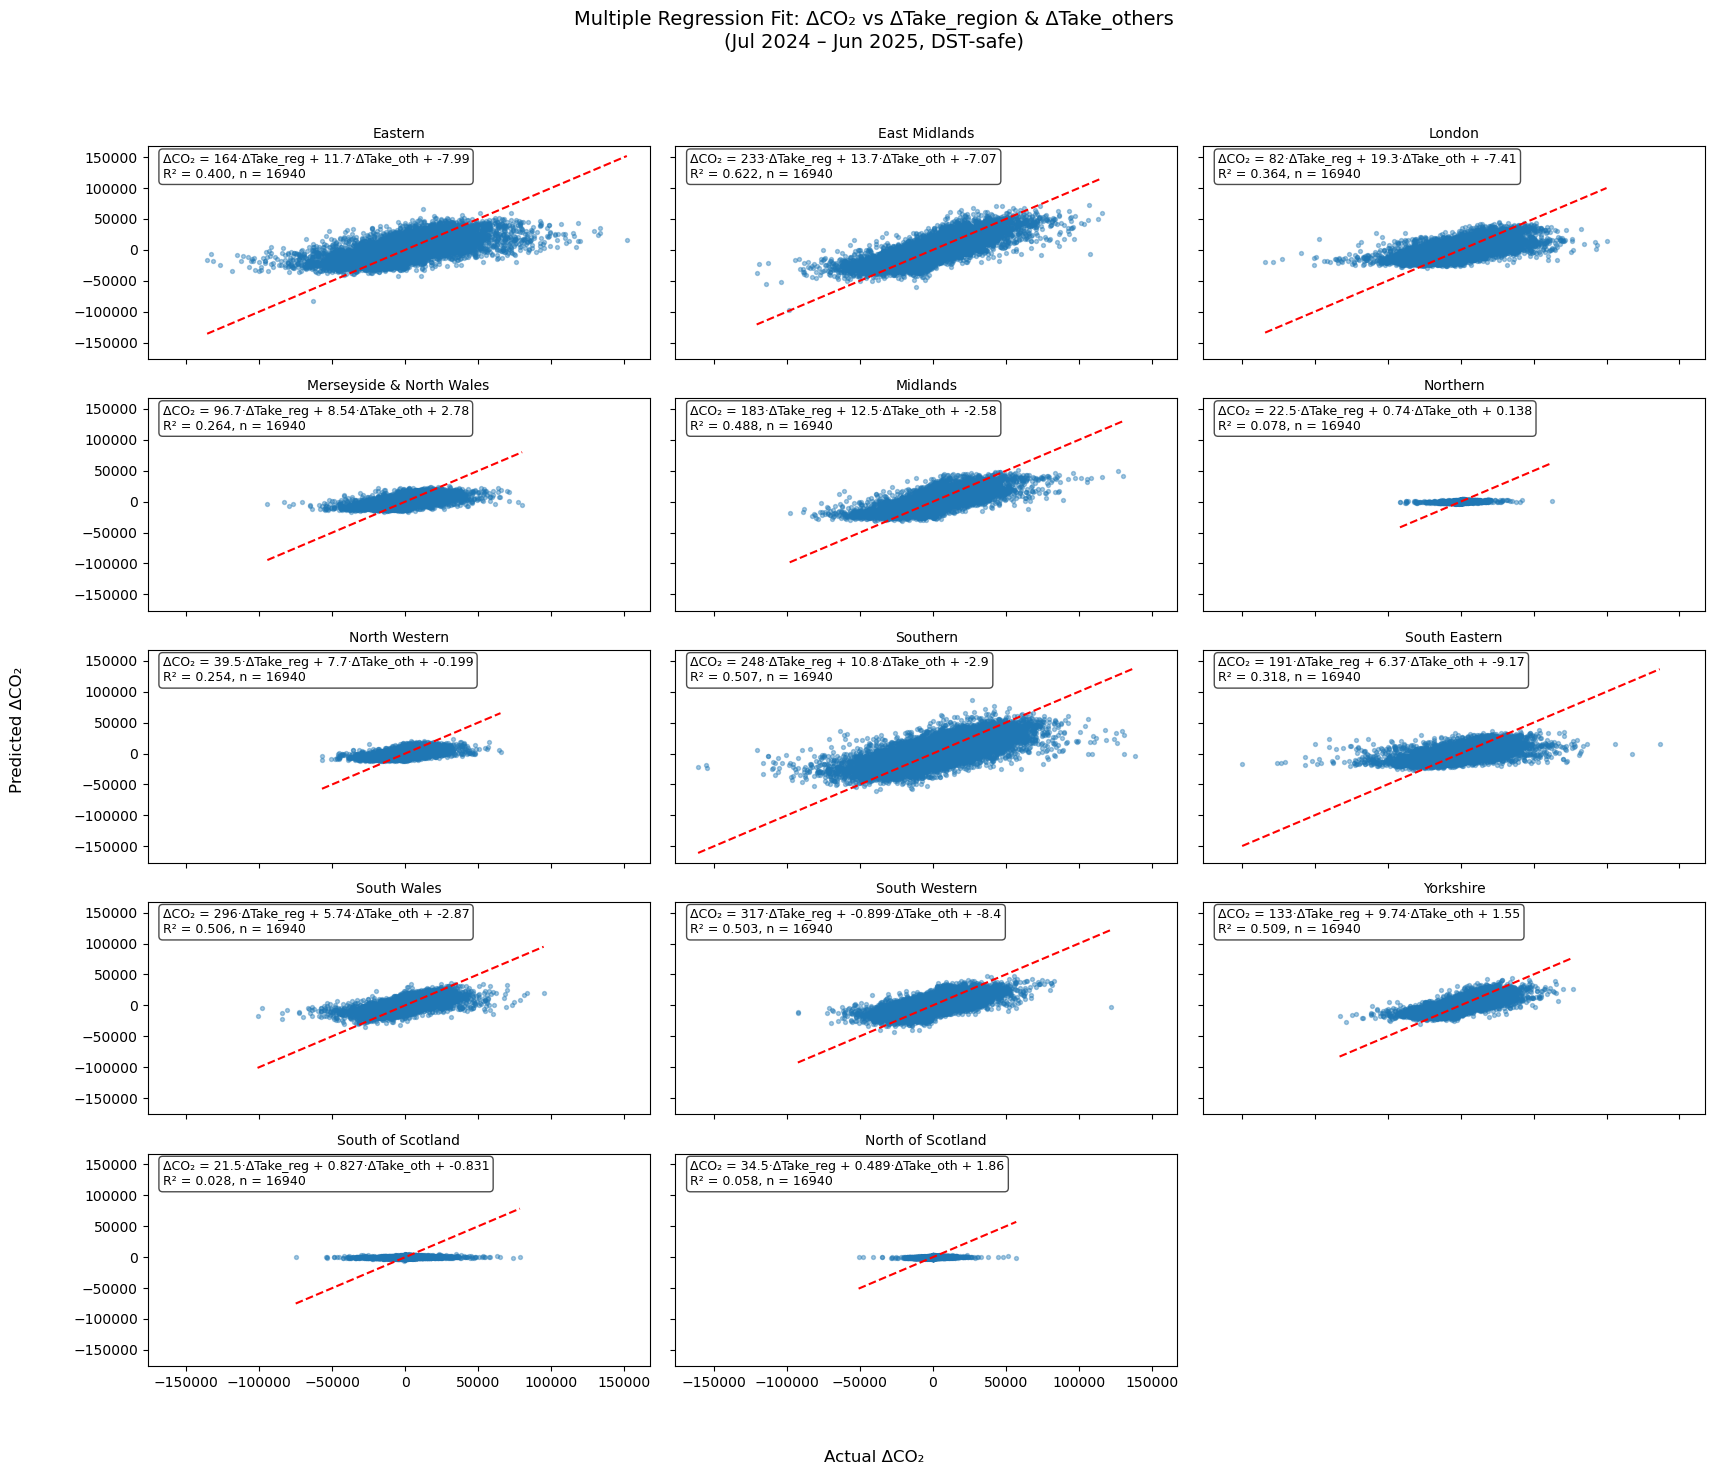

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# Precompute CO₂ for all regions
for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col in df.columns and ci_col in df.columns:
        df[f'CO2{code}'] = df[take_col] * df[ci_col]

# DST-safe "consecutive" logic
df['prev_date'] = df['SettlementDate'].shift(1)
df['prev_sp']   = df['SettlementPeriod'].shift(1)
max_sp_today = df.groupby('SettlementDate')['SettlementPeriod'].transform('max')
df['max_sp_today'] = max_sp_today
prev_max_map = df[['SettlementDate','max_sp_today']].drop_duplicates().set_index('SettlementDate')['max_sp_today']
df['max_sp_prev'] = df['prev_date'].map(prev_max_map)

same_day_next = (
    (df['SettlementDate'] == df['prev_date']) &
    (df['SettlementPeriod'] == df['prev_sp'] + 1)
)
wrap_new_day = (
    (df['SettlementDate'] != df['prev_date']) &
    (df['prev_sp'] == df['max_sp_prev']) &
    (df['SettlementPeriod'] == 1)
)
df['consecutive'] = same_day_next | wrap_new_day

# === Plot setup ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharex=True, sharey=True)
axes = axes.flatten()

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    take_col = f'GSP_Take{code}'
    co2_col  = f'CO2{code}'

    if take_col not in df.columns or co2_col not in df.columns:
        ax.set_visible(False)
        continue

    # ΔTake for region
    df['ΔTake_region'] = df[take_col].diff()
    df['ΔCO2_region']  = df[co2_col].diff()

    # ΔTake for all other regions
    other_takes = [f'GSP_Take{c}' for c in region_codes if c != code and f'GSP_Take{c}' in df.columns]
    df['Take_others'] = df[other_takes].sum(axis=1)
    df['ΔTake_others'] = df['Take_others'].diff()

    # Keep only consecutive SPs and valid data
    subset = df[df['consecutive']].dropna(subset=['ΔTake_region', 'ΔTake_others', 'ΔCO2_region']).copy()

    if len(subset) < 3:
        ax.set_visible(False)
        continue

    # Fit model
    X = subset[['ΔTake_region', 'ΔTake_others']].to_numpy()
    y = subset['ΔCO2_region'].to_numpy()
    reg = LinearRegression().fit(X, y)
    b0 = reg.intercept_
    b1, b2 = reg.coef_
    r2 = reg.score(X, y)
    n_points = len(subset)

    # Predictions
    y_pred = reg.predict(X)

    # Scatter actual vs predicted
    ax.scatter(y, y_pred, s=8, alpha=0.4)
    lims = [
        min(y.min(), y_pred.min()),
        max(y.max(), y_pred.max())
    ]
    ax.plot(lims, lims, 'r--', lw=1.5)  # 45° line
    ax.set_title(region_descriptions[code], fontsize=10)

    # Annotate equation
    ax.text(0.03, 0.97,
            f"ΔCO₂ = {b1:.3g}·ΔTake_reg + {b2:.3g}·ΔTake_oth + {b0:.3g}\n"
            f"R² = {r2:.3f}, n = {n_points}",
            ha='left', va='top', transform=ax.transAxes,
            fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Hide unused subplot
for j in range(len(region_codes), len(axes)):
    axes[j].axis('off')

# Shared labels
fig.supxlabel('Actual ΔCO₂', fontsize=12)
fig.supylabel('Predicted ΔCO₂', fontsize=12)
fig.suptitle('Multiple Regression Fit: ΔCO₂ vs ΔTake_region & ΔTake_others\n(Jul 2024 – Jun 2025, DST-safe)', fontsize=14)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()


In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# === Load & prep ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# Precompute CO2 = Take * CI for all available regions
for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col in df.columns and ci_col in df.columns:
        df[f'CO2{code}'] = df[take_col] * df[ci_col]

# DST-safe consecutiveness (handles 46/48/50 SP days)
df['prev_date'] = df['SettlementDate'].shift(1)
df['prev_sp']   = df['SettlementPeriod'].shift(1)
max_sp_today = df.groupby('SettlementDate')['SettlementPeriod'].transform('max')
df['max_sp_today'] = max_sp_today
prev_max_map = df[['SettlementDate','max_sp_today']].drop_duplicates().set_index('SettlementDate')['max_sp_today']
df['max_sp_prev'] = df['prev_date'].map(prev_max_map)
same_day_next = ((df['SettlementDate'] == df['prev_date']) & (df['SettlementPeriod'] == df['prev_sp'] + 1))
wrap_new_day  = ((df['SettlementDate'] != df['prev_date']) & (df['prev_sp'] == df['max_sp_prev']) & (df['SettlementPeriod'] == 1))
df['consecutive'] = same_day_next | wrap_new_day

# Annual Take totals & proportions (using raw Take)
take_cols = [f'GSP_Take{c}' for c in region_codes if f'GSP_Take{c}' in df.columns]
total_take_by_region = df[take_cols].sum(skipna=True)
grand_total_take = total_take_by_region.sum()
proportion_by_region = (total_take_by_region / grand_total_take) if grand_total_take != 0 else total_take_by_region * np.nan

# === Multiple regression and table assembly ===
rows = []
for code in region_codes:
    take_col = f'GSP_Take{code}'
    co2_col  = f'CO2{code}'
    if take_col not in df.columns or co2_col not in df.columns:
        continue

    # Δ for region
    d_take_region = df[take_col].diff()
    d_co2_region  = df[co2_col].diff()

    # Δ for all other regions
    other_takes = [f'GSP_Take{c}' for c in region_codes if c != code and f'GSP_Take{c}' in df.columns]
    if not other_takes:  # safety
        continue
    take_others = df[other_takes].sum(axis=1)
    d_take_others = take_others.diff()

    # Keep only consecutive pairs and valid data
    subset = pd.DataFrame({
        'ΔTake_region': d_take_region,
        'ΔTake_others': d_take_others,
        'ΔCO2_region':  d_co2_region,
        'consecutive':  df['consecutive']
    })
    subset = subset[subset['consecutive']].dropna(subset=['ΔTake_region','ΔTake_others','ΔCO2_region'])

    if len(subset) < 3:
        continue

    # Multiple regression
    X = subset[['ΔTake_region','ΔTake_others']].to_numpy()
    y = subset['ΔCO2_region'].to_numpy()
    reg = LinearRegression().fit(X, y)
    beta_region = float(reg.coef_[0])   # coefficient on ΔTake_region (β1)
    r2 = float(reg.score(X, y))
    n  = len(subset)

    rows.append({
        'RegionCode': code,
        'RegionName': region_descriptions.get(code, code),
        'Beta_region': beta_region,                      # requested coefficient
        'R2_multi': r2,
        'n': n,
        'AnnualTake': float(total_take_by_region.get(take_col, np.nan)),
        'ProportionOfTotalTake': float(proportion_by_region.get(take_col, np.nan))
    })

summary = pd.DataFrame(rows).sort_values('RegionName').reset_index(drop=True)

# Weighted average of Beta_region by proportion of total take
summary['WeightedCoeffComponent'] = summary['Beta_region'] * summary['ProportionOfTotalTake']
weighted_avg_beta = summary['WeightedCoeffComponent'].sum()

print(summary[['RegionCode','RegionName','Beta_region','ProportionOfTotalTake','R2_multi','n']])
print("\nWeighted average (β_region) by proportion of total take: {:.6g}".format(weighted_avg_beta))

# Optional export:
# summary.to_csv(r"C:\path\to\save\multi_reg_beta_region_weights.csv", index=False)


   RegionCode                RegionName  Beta_region  ProportionOfTotalTake  \
0          _B             East Midlands   233.176740               0.090217   
1          _A                   Eastern   163.962632               0.119503   
2          _C                    London    82.012503               0.110404   
3          _D  Merseyside & North Wales    96.688737               0.049974   
4          _E                  Midlands   182.877282               0.090750   
5          _G             North Western    39.463802               0.086332   
6          _P         North of Scotland    34.523927               0.006077   
7          _F                  Northern    22.459693               0.050187   
8          _J             South Eastern   190.936517               0.074119   
9          _K               South Wales   295.657404               0.033495   
10         _L             South Western   316.855624               0.043239   
11         _N         South of Scotland    21.479765

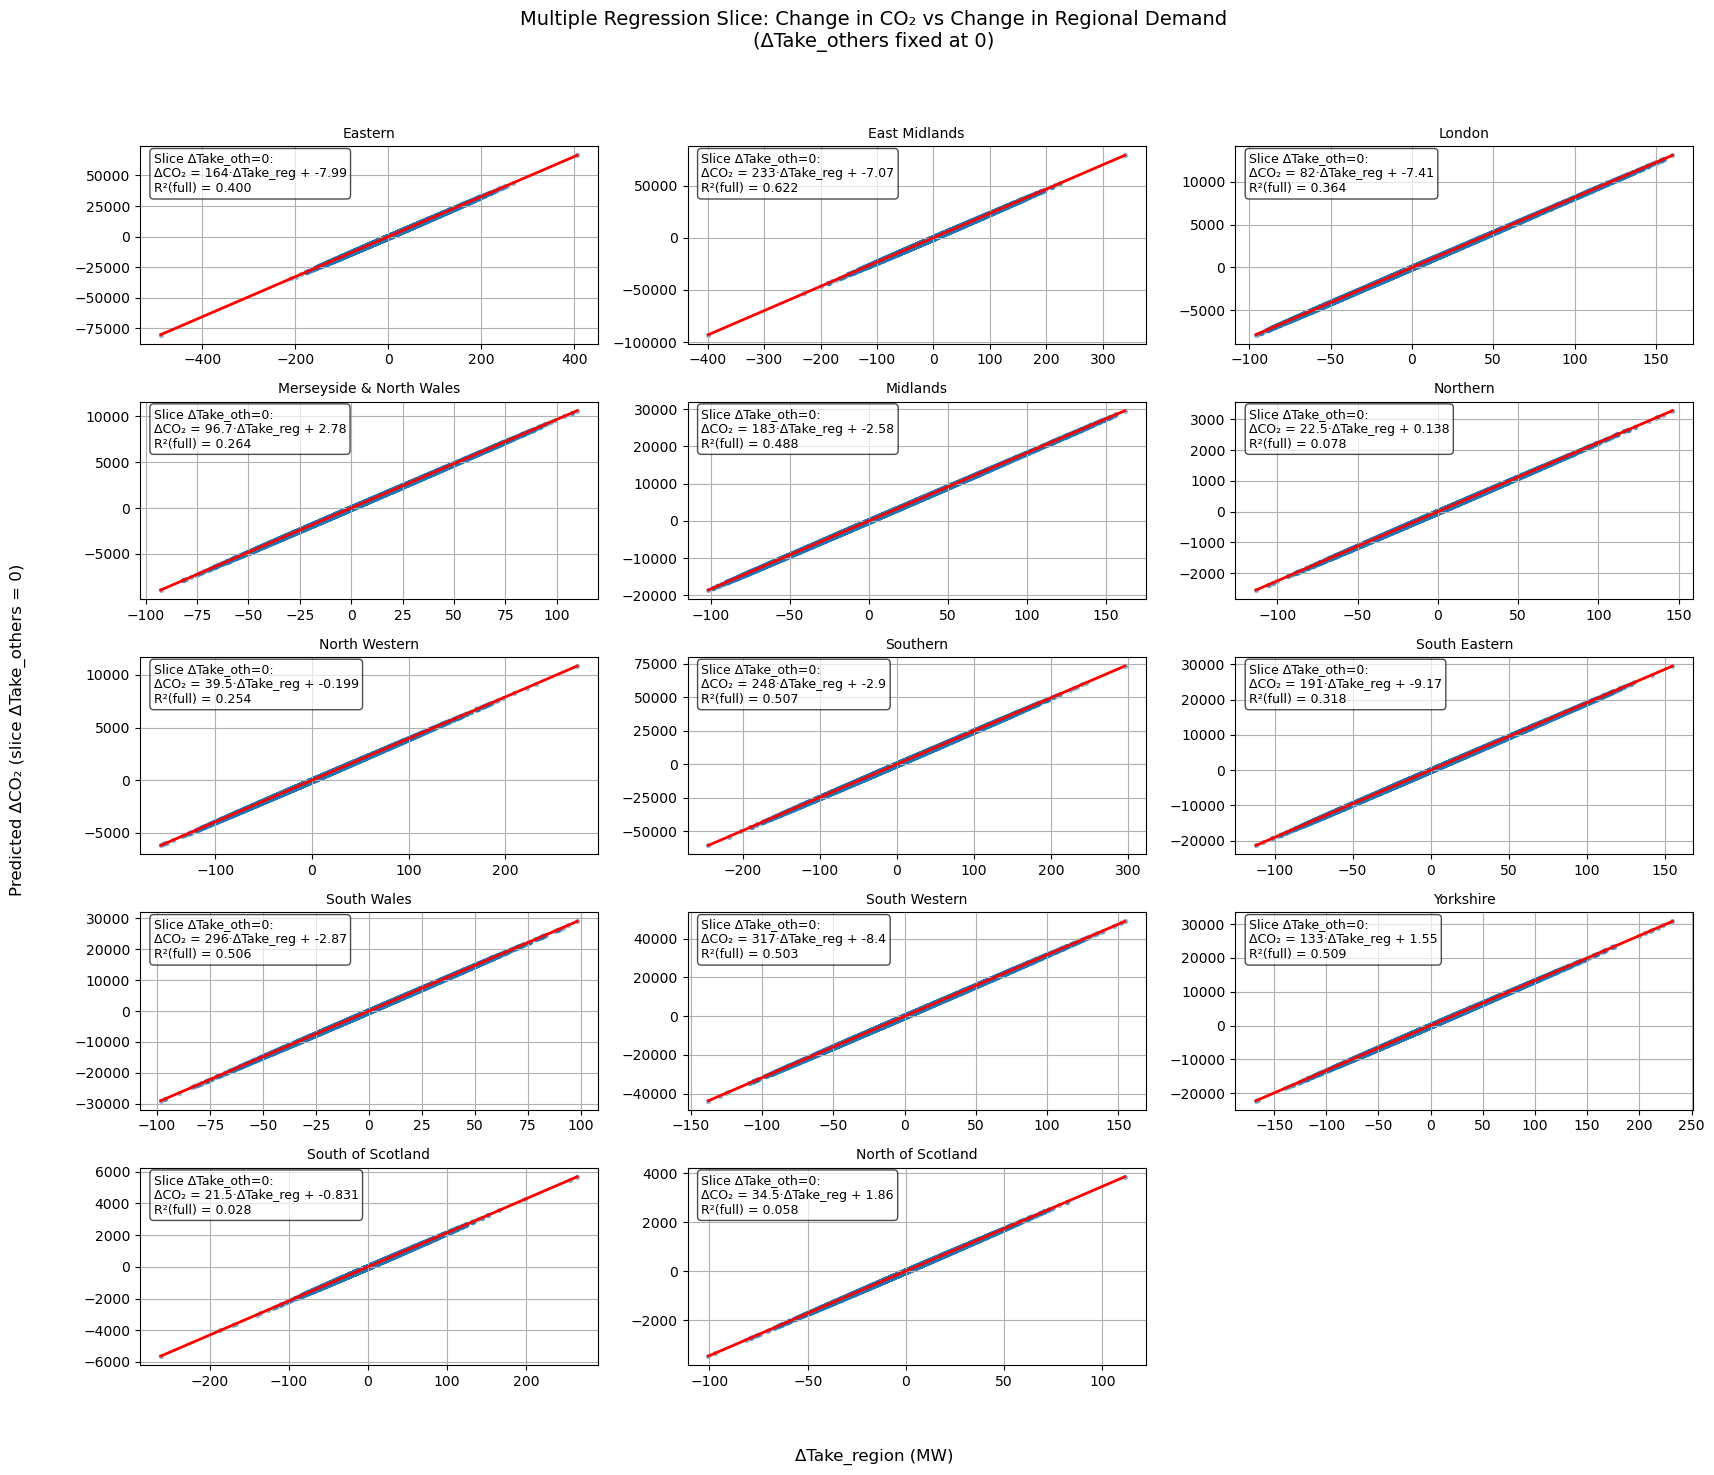

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# Precompute CO₂ for all regions
for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col in df.columns and ci_col in df.columns:
        df[f'CO2{code}'] = df[take_col] * df[ci_col]

# DST-safe consecutiveness
df['prev_date'] = df['SettlementDate'].shift(1)
df['prev_sp']   = df['SettlementPeriod'].shift(1)
max_sp_today = df.groupby('SettlementDate')['SettlementPeriod'].transform('max')
df['max_sp_today'] = max_sp_today
prev_max_map = df[['SettlementDate','max_sp_today']].drop_duplicates().set_index('SettlementDate')['max_sp_today']
df['max_sp_prev'] = df['prev_date'].map(prev_max_map)
same_day_next = ((df['SettlementDate'] == df['prev_date']) & (df['SettlementPeriod'] == df['prev_sp'] + 1))
wrap_new_day  = ((df['SettlementDate'] != df['prev_date']) & (df['prev_sp'] == df['max_sp_prev']) & (df['SettlementPeriod'] == 1))
df['consecutive'] = same_day_next | wrap_new_day

# === Plot setup ===
fig, axes = plt.subplots(5, 3, figsize=(18, 15), sharex=False, sharey=False)
axes = axes.flatten()

for idx, code in enumerate(region_codes):
    ax = axes[idx]
    take_col = f'GSP_Take{code}'
    co2_col  = f'CO2{code}'

    if take_col not in df.columns or co2_col not in df.columns:
        ax.set_visible(False)
        continue

    # Δ values
    df['ΔTake_region'] = df[take_col].diff()
    df['ΔCO2_region']  = df[co2_col].diff()
    other_takes = [f'GSP_Take{c}' for c in region_codes if c != code and f'GSP_Take{c}' in df.columns]
    df['ΔTake_others'] = df[other_takes].sum(axis=1).diff()

    # Filter
    subset = df[df['consecutive']].dropna(subset=['ΔTake_region','ΔTake_others','ΔCO2_region']).copy()
    if len(subset) < 3:
        ax.set_visible(False)
        continue

    # Fit multiple regression
    X = subset[['ΔTake_region','ΔTake_others']].to_numpy()
    y = subset['ΔCO2_region'].to_numpy()
    reg = LinearRegression().fit(X, y)
    b0, b1, b2 = reg.intercept_, *reg.coef_
    r2 = reg.score(X, y)

    # Slice with ΔTake_others = 0
    X_slice = np.column_stack([subset['ΔTake_region'].to_numpy(), np.zeros(len(subset))])
    y_pred_slice = reg.predict(X_slice)

    # Scatter + fit line for the slice
    ax.scatter(subset['ΔTake_region'], y_pred_slice, s=8, alpha=0.4)
    x_line = np.linspace(subset['ΔTake_region'].min(), subset['ΔTake_region'].max(), 100)
    ax.plot(x_line, b0 + b1*x_line + b2*0, color='red', lw=2)

    ax.set_title(region_descriptions[code], fontsize=10)
    ax.text(0.03, 0.97,
            f"Slice ΔTake_oth=0:\nΔCO₂ = {b1:.3g}·ΔTake_reg + {b0:.3g}\nR²(full) = {r2:.3f}",
            ha='left', va='top', transform=ax.transAxes,
            fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    ax.grid(True)

# Hide unused axes
for j in range(len(region_codes), len(axes)):
    axes[j].axis('off')

fig.supxlabel('ΔTake_region (MW)', fontsize=12)
fig.supylabel('Predicted ΔCO₂ (slice ΔTake_others = 0)', fontsize=12)
fig.suptitle('Multiple Regression Slice: Change in CO₂ vs Change in Regional Demand\n(ΔTake_others fixed at 0)', fontsize=14)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()


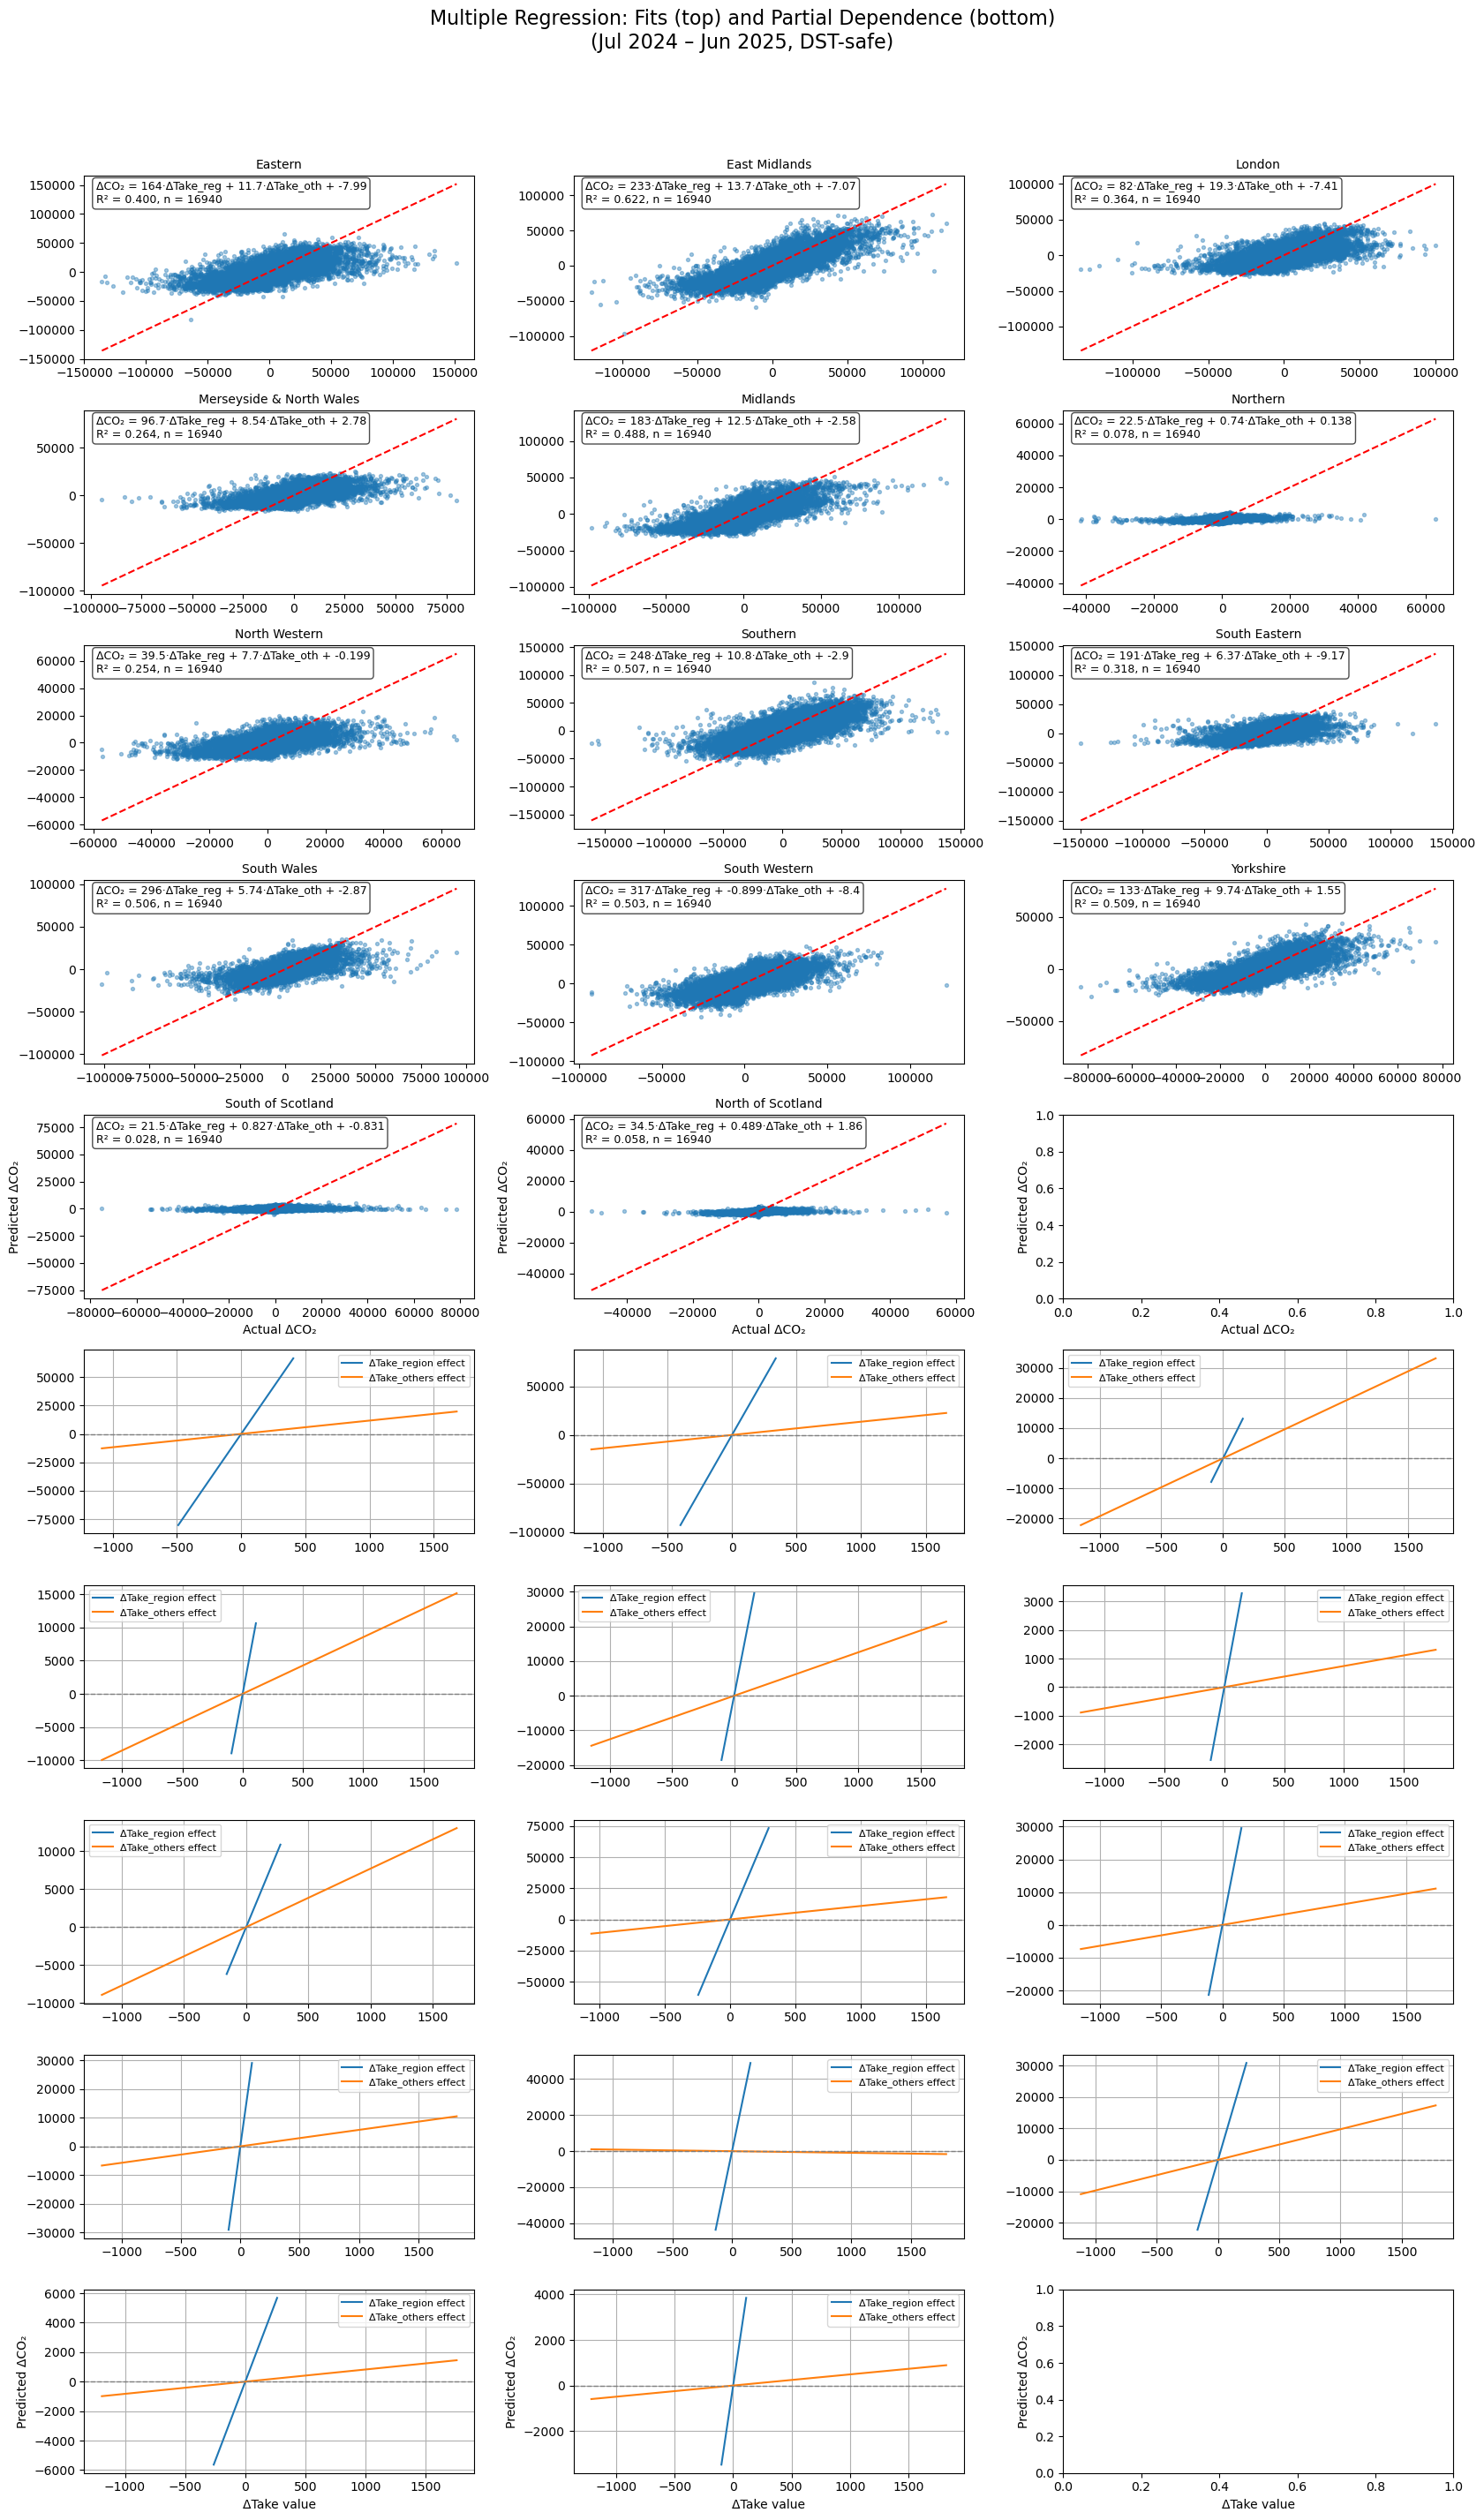

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# === Load data ===
csv_path = r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Data_1Jul24_to_30Jun25.csv"
df = pd.read_csv(csv_path)

# Parse datetime
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], format="%d/%m/%Y")
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df['SettlementPeriod'] = df['SettlementPeriod'].astype(int)
df = df.sort_values(['SettlementDate', 'SettlementPeriod'])

region_codes = ['_A','_B','_C','_D','_E','_F','_G','_H','_J','_K','_L','_M','_N','_P']
region_descriptions = {
    '_A': 'Eastern', '_B': 'East Midlands', '_C': 'London', '_D': 'Merseyside & North Wales',
    '_E': 'Midlands', '_F': 'Northern', '_G': 'North Western', '_H': 'Southern',
    '_J': 'South Eastern', '_K': 'South Wales', '_L': 'South Western', '_M': 'Yorkshire',
    '_N': 'South of Scotland', '_P': 'North of Scotland'
}

# Precompute CO₂ for all regions
for code in region_codes:
    take_col = f'GSP_Take{code}'
    ci_col   = f'CarbonIntensityForecast{code}'
    if take_col in df.columns and ci_col in df.columns:
        df[f'CO2{code}'] = df[take_col] * df[ci_col]

# DST-safe consecutive SPs
df['prev_date'] = df['SettlementDate'].shift(1)
df['prev_sp']   = df['SettlementPeriod'].shift(1)
max_sp_today = df.groupby('SettlementDate')['SettlementPeriod'].transform('max')
df['max_sp_today'] = max_sp_today
prev_max_map = df[['SettlementDate','max_sp_today']].drop_duplicates().set_index('SettlementDate')['max_sp_today']
df['max_sp_prev'] = df['prev_date'].map(prev_max_map)
same_day_next = (
    (df['SettlementDate'] == df['prev_date']) &
    (df['SettlementPeriod'] == df['prev_sp'] + 1)
)
wrap_new_day = (
    (df['SettlementDate'] != df['prev_date']) &
    (df['prev_sp'] == df['max_sp_prev']) &
    (df['SettlementPeriod'] == 1)
)
df['consecutive'] = same_day_next | wrap_new_day

# === Plot setup ===
fig, axes = plt.subplots(10, 3, figsize=(18, 30))  # doubled rows (fit + PDP)
axes = axes.reshape(2, 5, 3)  # two "layers" of 5x3 plots

for idx, code in enumerate(region_codes):
    row, col = divmod(idx, 3)
    ax_fit = axes[0, row, col]  # first layer for fit
    ax_pdp = axes[1, row, col]  # second layer for PDP

    take_col = f'GSP_Take{code}'
    co2_col  = f'CO2{code}'

    if take_col not in df.columns or co2_col not in df.columns:
        ax_fit.set_visible(False)
        ax_pdp.set_visible(False)
        continue

    # ΔTake for region
    df['ΔTake_region'] = df[take_col].diff()
    df['ΔCO2_region']  = df[co2_col].diff()

    # ΔTake for all other regions
    other_takes = [f'GSP_Take{c}' for c in region_codes if c != code and f'GSP_Take{c}' in df.columns]
    df['Take_others'] = df[other_takes].sum(axis=1)
    df['ΔTake_others'] = df['Take_others'].diff()

    # Keep only consecutive SPs and valid data
    subset = df[df['consecutive']].dropna(subset=['ΔTake_region', 'ΔTake_others', 'ΔCO2_region']).copy()
    if len(subset) < 3:
        ax_fit.set_visible(False)
        ax_pdp.set_visible(False)
        continue

    # Fit model
    X = subset[['ΔTake_region', 'ΔTake_others']].to_numpy()
    y = subset['ΔCO2_region'].to_numpy()
    reg = LinearRegression().fit(X, y)
    b0, b1, b2 = reg.intercept_, *reg.coef_
    r2 = reg.score(X, y)
    n_points = len(subset)

    # Predictions for fit plot
    y_pred = reg.predict(X)
    ax_fit.scatter(y, y_pred, s=8, alpha=0.4)
    lims = [min(y.min(), y_pred.min()), max(y.max(), y_pred.max())]
    ax_fit.plot(lims, lims, 'r--', lw=1.5)
    ax_fit.set_title(region_descriptions[code], fontsize=10)
    ax_fit.text(0.03, 0.97,
                f"ΔCO₂ = {b1:.3g}·ΔTake_reg + {b2:.3g}·ΔTake_oth + {b0:.3g}\n"
                f"R² = {r2:.3f}, n = {n_points}",
                ha='left', va='top', transform=ax_fit.transAxes,
                fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    # Partial dependence plots
    mean_region = 0
    mean_others = 0

    # PDP for ΔTake_region
    reg_range = np.linspace(subset['ΔTake_region'].min(), subset['ΔTake_region'].max(), 50)
    X_pdp_reg = np.column_stack([reg_range, np.full_like(reg_range, mean_others)])
    y_pdp_reg = reg.predict(X_pdp_reg)

    # PDP for ΔTake_others
    oth_range = np.linspace(subset['ΔTake_others'].min(), subset['ΔTake_others'].max(), 50)
    X_pdp_oth = np.column_stack([np.full_like(oth_range, mean_region), oth_range])
    y_pdp_oth = reg.predict(X_pdp_oth)

    ax_pdp.plot(reg_range, y_pdp_reg, label='ΔTake_region effect')
    ax_pdp.plot(oth_range, y_pdp_oth, label='ΔTake_others effect')
    ax_pdp.axhline(0, color='grey', linestyle='--', linewidth=1)
    ax_pdp.legend(fontsize=8)
    ax_pdp.grid(True)

# Shared labels
for col in range(3):
    axes[0, -1, col].set_xlabel('Actual ΔCO₂')
    axes[0, -1, col].set_ylabel('Predicted ΔCO₂')
    axes[1, -1, col].set_xlabel('ΔTake value')
    axes[1, -1, col].set_ylabel('Predicted ΔCO₂')

fig.suptitle('Multiple Regression: Fits (top) and Partial Dependence (bottom)\n(Jul 2024 – Jun 2025, DST-safe)', fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.show()
